<h1 id="tocheading">Table of Contents</h1>
<br />
<div id="toc"><ul class="toc"><li><a href="#1.-Display-tables-in-database">1. Display tables in database</a><a class="anchor-link" href="#1.-Display-tables-in-database">¶</a></li><li><a href="#2.-Selecting-Albums-to-Purchase">2. Selecting Albums to Purchase</a><a class="anchor-link" href="#2.-Selecting-Albums-to-Purchase">¶</a></li><ul class="toc"><li><a href="#2.1.-Most-popular-genres-(by-amount-of-dollars-paid)">2.1. Most popular genres (by amount of dollars paid)</a><a class="anchor-link" href="#2.1.-Most-popular-genres-(by-amount-of-dollars-paid)">¶</a></li><li><a href="#2.2.-Most-popular-genres-(by-number-of-tracks-sold)">2.2. Most popular genres (by number of tracks sold)</a><a class="anchor-link" href="#2.2.-Most-popular-genres-(by-number-of-tracks-sold)">¶</a></li></ul><li><a href="#3.-Analyzing-Employee-Sales-Performance">3. Analyzing Employee Sales Performance</a><a class="anchor-link" href="#3.-Analyzing-Employee-Sales-Performance">¶</a></li><li><a href="#4.-Analyzing-Sales-by-Country">4. Analyzing Sales by Country</a><a class="anchor-link" href="#4.-Analyzing-Sales-by-Country">¶</a></li><li><a href="#5.-Visualizing-Sales-by-Country">5. Visualizing Sales by Country</a><a class="anchor-link" href="#5.-Visualizing-Sales-by-Country">¶</a></li><li><a href="#6.-Albums-vs-Individual-Tracks">6. Albums vs Individual Tracks</a><a class="anchor-link" href="#6.-Albums-vs-Individual-Tracks">¶</a></li><li><a href="#7.-Tasks-for-later">7. Tasks for later</a><a class="anchor-link" href="#7.-Tasks-for-later">¶</a></li></ul></div>

Project guide: https://www.dataquest.io/m/191/guided-project%3A-answering-business-questions-using-sql

Solution by DataQuest: https://github.com/dataquestio/solutions/blob/master/Mission191Solutions.ipynb

**<span style=color:red>Note: Most SQL queries in this project are not my original ones, but have been taken from DataQuest's solution. Especially, the entire code in [6. Albums vs Individual Tracks](#6.-Albums-vs-Individual-Tracks) is an exact copy of DataQuest's solution</span>**

This project uses `chinook.db` downloaded from DataQuest. The data is originally from https://github.com/lerocha/chinook-database.


"The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables."([source](https://www.dataquest.io/m/189/intermediate-joins-in-sql)).

Below is a schema diagram of the database provided by DataQuest.

![chinook-schema](chinook-schema.svg?sanitize=true)


# 1. Display tables in database

I will list all `tables` and `views` in the database. This is just for demonstration. The Schema contains all tables as shown below.

In [1]:
from IPython.display import display
from pprint import pprint
from shutil import copy

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3

%matplotlib inline

# create a copy of database. The copy will be used for this project.
copy("chinook-unmodified.db", "chinook.db")

db = "chinook.db"

def run_query(query):
    """
    query: "SELECT" statement
    db: database
    
    Run query on db.
    Then return result.
    """
    
    # connect to database
    with sqlite3.connect(db) as conn:
    
        # query database and return result
        return pd.read_sql(query, conn)

def run_command(command):
    """
    Command: Statement which does not return results
    (e.g. CREATE, INSERT)
    db: database
    
    Run command on db
    """
    
    # connect to database
    with sqlite3.connect(db) as conn:
    
        # run command
        pd.read_sql(query, conn)
    
def show_tables():
    """
    Return all tables and views in db (database).
    """
    
    # query to list tables and views
    # (details of sqlite_master's columns are in are at http://bit.ly/2BXeM5Z)
    query = """
    SELECT name, type
    FROM sqlite_master
    WHERE
    type in ("table", "view")
    """
    
    return run_query(query)

# show all tables in database
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# 2. Selecting Albums to Purchase

Here's the situation (excerpted from DataQuest).
____
The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

<table>
<thead>
<tr>
<th>Artist Name</th>
<th>Genre</th>
</tr>
</thead>
<tbody>
<tr>
<td>Regal</td>
<td>Hip-Hop</td>
</tr>
<tr>
<td>Red Tone</td>
<td>Punk</td>
</tr>
<tr>
<td>Meteor and the Girls</td>
<td>Pop</td>
</tr>
<tr>
<td>Slim Jim Bites</td>
<td>Blues</td>
</tr>
</tbody>
</table>

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.
___


## 2.1. Most popular genres (by amount of dollars paid)

So, what are the top 3 most sold genres among hip-hop, punk, pop and blues? I will first pick top three according to the sum in dollars.

,genre,dollars_sold,percentage_sold
0,Rock,5568.75,53.52%
1,Alternative & Punk,1234.53,11.86%
2,Metal,1025.64,9.86%
3,R&B/Soul,633.60,6.09%
4,Blues,453.42,4.36%
5,Alternative,369.27,3.55%
6,Hip Hop/Rap,366.30,3.52%
7,Pop,201.96,1.94%
8,Latin,162.36,1.56%
9,Jazz,125.73,1.21%


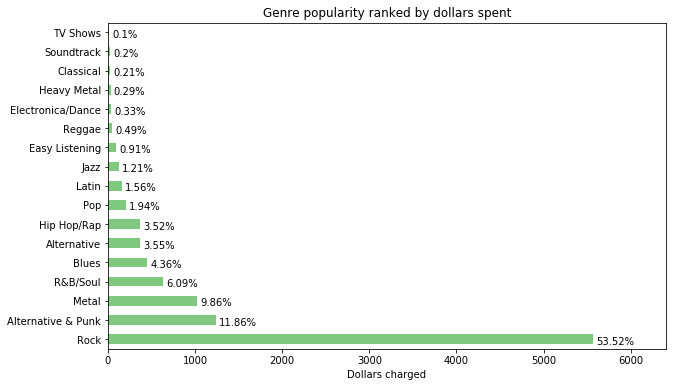

In [2]:
import plotly
from plotly.graph_objs import Scatter, Layout

def draw_plot(df, kind, cols_show, col_annot=None, \
              annot_x_ratio=None, annot_y_ratio=None, \
              xlabel="", ylabel="", cmap=cm.Accent, title="", \
              figsize=(10, 6), horizontalalignment="left", col_additional=None, bubble_scale=0.5):
    """
    df: pandas data frame
    kind: kind of plot
    xlim: x-axis range
    cols_show: df's columns containing data to display
    col_annot: source from which to take annotation text.
        This can be either (1) df's column or (2) "index"
    annot_x_ratio, annot_y_ratio: used for adjusting annotation position
    xlabel, ylabel: Labels for x and y axes
    color: color for plot.
    
    
    Draw specified kind of plot for series
    """
    
    # create plot
    fig = plt.figure()
    
    # get colun names and ranges for x and y axes 
    if type(cols_show) == list:
        x, y = cols_show[0], cols_show[1]
        xlim = (0, df[cols_show[0]].max() * 1.15)
        ylim = (0, df[cols_show[1]].max() * 1.15)
    else:
        di = df.index
        x, y = cols_show, di.name
        xlim = (0, df[x].max() * 1.15)
        ylim = (0, di.values.max() * 1.15) if di.dtype in (int, float) \
               else None
        
    # draw plots
    if kind is "bubble":
        drawBubbleChart(df, x, y, col_annot, col_additional, xlabel, ylabel, title, bubble_scale)
    else:
        
        
        if kind is "scatter":
            s = df[col_additional] * 5 if col_additional else None # size of marker
            df[cols_show].plot(x=x, y=y, color="green", kind=kind, xlim=xlim, ylim=ylim, \
                           title=title, figsize=figsize, s=s)
        else:
            df[cols_show].plot(kind=kind, cmap=cmap, xlim=xlim, ylim=ylim, title=title, figsize=figsize)
    
        # x and y axis labels
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    # annotation
    if col_annot and (kind is not "bubble"):
        
        # get figure dimensions (source https://stackoverflow.com/a/29702596)
        fig_dim = fig.get_size_inches() * fig.dpi
        
        for i, v in enumerate(list(df.index)):
            
            # annotation from index
            if col_annot == "index":
                annot = v
                x_coor = df[x][i]
                y_coor = df[y][i]
                
            # annotation from column
            else:
                x_coor = df.loc[v, x]
                y_coor = i
                annot = "{}".format(df.loc[v, col_annot])
            
            # annotate
            plt.annotate(annot, xy=(x_coor + fig_dim[0] * annot_x_ratio, y_coor - fig_dim[1] * annot_y_ratio),
                        horizontalalignment=horizontalalignment)
    
    plt.show()
    
def drawBubbleChart(df, x, y, col_annot, col_additional, xlabel, ylabel, title, bubble_scale):
    
    # set bubble plot parameters
    col_annot = df.index if col_annot == "index" \
                  else df[col_annot]

    data = []
    hover_text = []
    
    for v in col_annot.values:
        condition = (col_annot.values == v)
        bubble = df[condition][col_additional]
        
        data.append({
                    'x': df[condition][x], 
                    'y': df[condition][y], 
                    'text': col_additional.replace("_", " ").capitalize() + \
                            ":<br>" + \
                            str(round(bubble.values[0], 2)),
                    'mode': 'markers',
                    'name': v,
                    'marker': dict(size=bubble * bubble_scale)
        })
        
    # initiate plotly offline mode
    plotly.offline.init_notebook_mode(connected=True)

    fig = {
        'data': data,
        'layout': {
            'title': title,
            'xaxis': {'title': xlabel, 'type': 'log'},
            'yaxis': {'title': ylabel}
        }
    }
    
    # draw plot
    plotly.offline.iplot(fig)
    
    plt.show()
    
query = """
WITH genre_sales AS (
    SELECT
        g.name genre,
        t.track_id,
        i.total,
        c.country
    FROM customer c
        LEFT JOIN invoice i
            ON i.customer_id == c.customer_id
        LEFT JOIN invoice_line il
            ON il.invoice_id == i.invoice_id
        LEFT JOIN track t
            ON t.track_id == il.track_id
        LEFT JOIN genre g
            ON g.genre_id == t.genre_id
    WHERE c.country == "USA"
)

SELECT
    genre,
    SUM(total) dollars_sold,
    ROUND(
        CAST(SUM(total) AS FLOAT) / (
                SELECT SUM(total) FROM genre_sales
                ) * 100
        , 2) || "%" percentage_sold
FROM
    genre_sales
GROUP BY genre
ORDER BY dollars_sold DESC;
"""

# table
genre_sales_usa = run_query(query)
display(genre_sales_usa)

# plot
genre_sales_usa.set_index('genre', inplace=True)
kind = "barh"
draw_plot(genre_sales_usa, kind, "dollars_sold", "percentage_sold", \
          annot_x_ratio=0.05, annot_y_ratio=0.0006, title="Genre popularity ranked by dollars spent", \
         xlabel="Dollars charged")

Punk, blues and hip-hop came above pop.

However, the sum in dollars is $number\ of\ tracks$ multiplied by $price\ per\ track$, and prices may not be fixed across time and regions.

## 2.2. Most popular genres (by number of tracks sold)
So, I will pick top three according to the number of tracks sold instead.

,genre,tracks_sold,percentage_sold
0,Rock,561,53.38%
1,Alternative & Punk,130,12.37%
2,Metal,124,11.8%
3,R&B/Soul,53,5.04%
4,Blues,36,3.43%
5,Alternative,35,3.33%
6,Latin,22,2.09%
7,Pop,22,2.09%
8,Hip Hop/Rap,20,1.9%
9,Jazz,14,1.33%


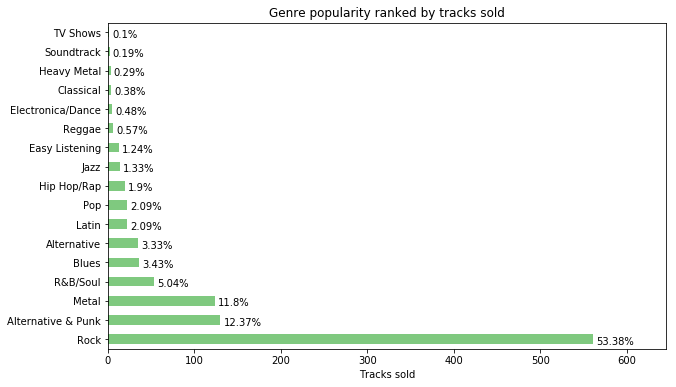

In [3]:
query = """
WITH genre_sales AS (
    SELECT
        g.name genre,
        t.track_id,
        i.total,
        c.country
    FROM customer c
        LEFT JOIN invoice i
            ON i.customer_id == c.customer_id
        LEFT JOIN invoice_line il
            ON il.invoice_id == i.invoice_id
        LEFT JOIN track t
            ON t.track_id == il.track_id
        LEFT JOIN genre g
            ON g.genre_id == t.genre_id
    WHERE c.country == "USA"
)

SELECT
    genre,
    COUNT(track_id) tracks_sold,
    ROUND(
        CAST(COUNT(track_id) AS FLOAT) / (
            SELECT COUNT(track_id) FROM genre_sales
            ) * 100
        , 2) || "%" percentage_sold 

FROM
    genre_sales
GROUP BY genre
ORDER BY tracks_sold DESC;
"""

# table
genre_sales_usa = run_query(query)
display(genre_sales_usa)

# plot
genre_sales_usa.set_index('genre', inplace=True)
kind = "barh"
draw_plot(genre_sales_usa, kind, "tracks_sold", "percentage_sold", \
          annot_x_ratio=0.005, annot_y_ratio=0.0006, title="Genre popularity ranked by tracks sold", \
         xlabel="Tracks sold")

Punk, blues and pop are ranked above hip-hop. So, hip-hop shall be dropped.

# 3. Analyzing Employee Sales Performance

Situation is described below (excerpt from DataQuest)
___
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.
___



,employee_id,full_name,total,hire_date,MAX(i.invoice_date),days_from_hiring_to_last_invoice
0,3,Jane Peacock,1731.51,2017-04-01 00:00:00,2020-12-30 00:00:00,1369.0
1,4,Margaret Park,1584.00,2017-05-03 00:00:00,2020-12-29 00:00:00,1336.0
2,5,Steve Johnson,1393.92,2017-10-17 00:00:00,2020-12-20 00:00:00,1160.0


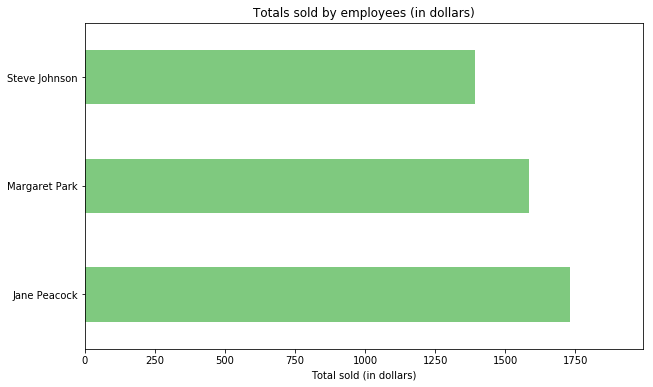

<Figure size 432x288 with 0 Axes>

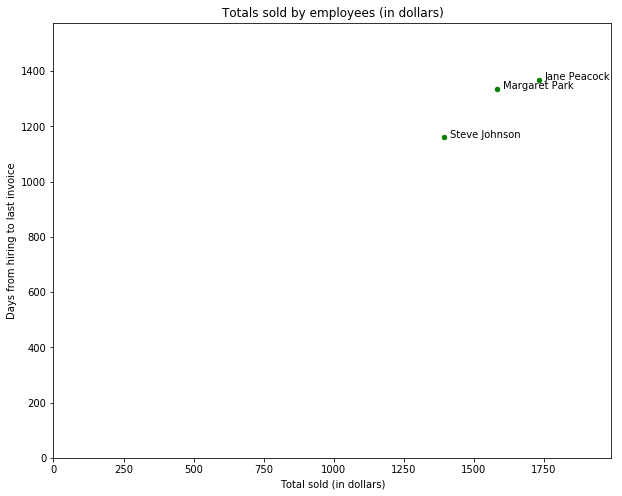

In [4]:
# create query
query = """
SELECT
    e.employee_id,
    e.first_name || ' ' || e.last_name full_name,
    SUM(i.total) total,
    e.hire_date,
    MAX(i.invoice_date),
    julianday(i.invoice_date) - julianday(e.hire_date) days_from_hiring_to_last_invoice
FROM employee e
    INNER JOIN customer c
        ON c.support_rep_id == e.employee_id
    INNER JOIN invoice i
        ON i.customer_id == c.customer_id
GROUP BY e.employee_id
ORDER BY total DESC;
"""

# table
employee_performance = run_query(query)
display(employee_performance)

# plot
employee_performance.set_index('full_name', inplace=True)
kind = "barh"
x_col = "total"
title = "Totals sold by employees (in dollars)"
xlabel = "Total sold (in dollars)"

draw_plot(employee_performance, kind, "total", \
          annot_x_ratio=0.005, annot_y_ratio=0.0006, title=title, \
         xlabel=xlabel)

# employee_performance["full_name"] = employee_performance.index
# employee_performance.set_index('total', inplace=True)
kind = "scatter"
y_col = "days_from_hiring_to_last_invoice"
ylabel = y_col.replace("_", " ").capitalize()
ylim = (0, employee_performance[y_col].max() * 1.15)
draw_plot(employee_performance, kind, [x_col, y_col], "index", \
          annot_x_ratio=0.05, annot_y_ratio=(0), title=title, \
         xlabel=xlabel, ylabel=ylabel, figsize=(10, 8))

Three employees have been found to have sold records. Overall, longer employment period meant more sales.

# 4. Analyzing Sales by Country

A table will be created where countries will be sorted by the amount of total sales (in dollars). For each country, average purchase per customer and average purchase per order (both in dollars) will be calculated.

Any country with only one customer will be categorised as "Other" which will be placed at the bottom of the table.

In [5]:
# create query
query = """
WITH ciu AS (
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer
                WHERE customer.country == c.country
                ) == 1 THEN "Other"
            ELSE c.country
            END AS country,
        c.customer_id,
        il.*
    FROM
        customer c
LEFT JOIN invoice i
    ON c.customer_id == i.customer_id
LEFT JOIN invoice_line il
    ON i.invoice_id == il.invoice_id
)


SELECT
    country,
    sales_total,
    sales_total_percentage,
    customer_count,
    sales_average_per_customer,
    order_count,
    sales_average_per_order
FROM
    (
    SELECT
        country,
        SUM(unit_price) sales_total,
        ROUND(
            SUM(unit_price) / 
                (SELECT SUM(unit_price)
                FROM ciu) * 100
            , 2) || "%" sales_total_percentage,
        COUNT(DISTINCT customer_id) customer_count,
        SUM(unit_price) / COUNT(DISTINCT customer_id) sales_average_per_customer,
        COUNT(DISTINCT invoice_id) order_count,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) sales_average_per_order,
        CASE
            WHEN country == "Other" THEN 1
            ELSE 0
            END customers_per_country
    FROM
        ciu
    GROUP BY country
    )
ORDER BY
    customers_per_country,
    sales_total DESC;
"""

country_sales = run_query(query)
display(country_sales)

,country,sales_total,sales_total_percentage,customer_count,sales_average_per_customer,order_count,sales_average_per_order
0,USA,1040.49,22.09%,13,80.037692,131,7.942672
1,Canada,535.59,11.37%,8,66.948750,76,7.047237
2,Brazil,427.68,9.08%,5,85.536000,61,7.011148
3,France,389.07,8.26%,5,77.814000,50,7.781400
4,Germany,334.62,7.11%,4,83.655000,41,8.161463
5,Czech Republic,273.24,5.8%,2,136.620000,30,9.108000
6,United Kingdom,245.52,5.21%,3,81.840000,28,8.768571
7,Portugal,185.13,3.93%,2,92.565000,29,6.383793
8,India,183.15,3.89%,2,91.575000,21,8.721429
9,Other,1094.94,23.25%,15,72.996000,147,7.448571


Excluding countries in `Other` category, people in `USA` spent most on records, almost twice as much as those in Canadians who came in the second place (see `sales_total` column).

Interestingly, Czech Republic showed highest expenditures per customer and per order (see `sales_average_per_customer` and `sales_average_per_order` columns). Howerver, their total expenditures were mediocore because of relatively small numbers of customers and purchases.


# 5. Visualizing Sales by Country

Now, the above table is visualised. Beware that the x-axis is not scaled linearly.

In [6]:
country_sales.set_index('country', inplace=True)

# plot (customer_count)s
kind = "bubble"
draw_plot(country_sales, kind, ["sales_total", "customer_count"], \
          col_annot="index",
          annot_x_ratio=-0.01, annot_y_ratio=0.0004, \
          title="Total sales, customer count and each customer's purchase", \
          xlabel="Total sales", ylabel="Customer count", \
          col_additional="sales_average_per_customer")

# plot (order_count)
kind = "bubble"
draw_plot(country_sales, kind, ["sales_total", "order_count"], \
          col_annot="index",
          annot_x_ratio=-0.01, annot_y_ratio=0.0004, \
          title="Total sales, order count and purchase per order", \
          xlabel="Total sales", ylabel="Order count", \
          col_additional="sales_average_per_order", \
          bubble_scale=7)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Overall, countries with more customers or orders displayed higher total purchases.

On the other hand, purchases per customer or per order did not show correlation with total purchases.

Note that these suggestions have not been tested statistically.

# 6. Albums vs Individual Tracks

The system allows customers to purchase either a whole album at a time or individual tracks. If an album is purchased, individual tracks cannot be added to the same purchase.

The question I will ask here is which way the customers make purchases more often. Do they buy whole albumns? Or do they buy tracks individually?

It is possible for a customer to select all tracks in an album individually and then add other tracks. But, let's ignore this case for simplicity.

**<span style=color:red>Note: The following cell is an exact copy of DataQuest's solution.</span>**

In [7]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Tracks are bought individually more often than as whole albumns.

# 7. Tasks for later

* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?